# Synchronous Execution
This notebooks showcases a demo of the synchronous execution capabilities of the APEx Dispatch API. In this notebook we will be using an openEO UDP to generate statistics on the fly.

In [1]:
%pip install authlib matplotlib

Note: you may need to restart the kernel to use updated packages.


Could not find platform independent libraries <prefix>

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import requests
import time
import matplotlib.pyplot as plt
from datetime import datetime
from authlib.integrations.requests_client import OAuth2Session
from urllib.parse import urlparse, parse_qs
from IPython.display import JSON

## Statistics UDP

In [2]:
udp_url = "https://openeo.vito.be/openeo/1.2/processes/u:ff5c137fbbbf409d14a99875b97109874058056a9a02193e6fde8217d2f1f3e8@egi.eu/timeseries_graph" 

In [3]:
JSON(requests.get(udp_url).json())

<IPython.core.display.JSON object>

### Parameters

In [4]:
dispatch_api = "localhost:8000"

In [5]:
point = [5.196363779293476, 51.25007554845948]

In [6]:
temporal_extent = ["2025-01-01", "2025-06-01"]

In [7]:
backend_url = "https://openeo.vito.be"
collection = "CGLS_NDVI300_V2_GLOBAL" 
band = "NDVI" 

## Authentication with the API
To access the different endpoints of the Dispatcher API it is important to first authenticate yourself with the APEx environment.

In [8]:
KEYCLOAK_HOST = "auth.dev.apex.esa.int"
CLIENT_ID = "apex-dispatcher-api-dev"

In [9]:
# Endpoints
authorization_endpoint = f"https://{KEYCLOAK_HOST}/realms/apex/protocol/openid-connect/auth"
token_endpoint = f"https://{KEYCLOAK_HOST}/realms/apex/protocol/openid-connect/token"

# Global token store
_token_data = None

def get_access_token():
    """
    Returns a valid access token. Refreshes it automatically if expired.
    """
    global _token_data

    # If we have a token and it hasn't expired yet, return it
    if _token_data and _token_data.get("expires_at", 0) > time.time() + 10:
        return _token_data["access_token"]

    # If token exists but is expired and has a refresh_token, refresh it
    if _token_data and "refresh_token" in _token_data:
        session = OAuth2Session(CLIENT_ID, token=_token_data)
        _token_data = session.refresh_token(token_endpoint)
        return _token_data["access_token"]

    # Otherwise, start a new OAuth2 flow
    session = OAuth2Session(
        client_id=CLIENT_ID,
        redirect_uri="http://localhost:8000/callback"
    )
    uri, state = session.create_authorization_url(authorization_endpoint)
    print("Open this URL in your browser:", uri)
    redirect_url = input("Paste the redirect URL here: ")
    parsed = urlparse(redirect_url)
    code = parse_qs(parsed.query).get("code")[0]

    _token_data = session.fetch_token(
        token_endpoint,
        code=code,
        client_secret=None,  # only if your client is confidential
        include_client_id=True
    )

    return _token_data["access_token"]

## Launching the synchronous xecution task

Next we trigger the synchronous execution task on the dispatcher. We provide the details of the processing job that needs to be executed. The result is the information on the created service execution task.

In [10]:
%%time
execution_task = requests.post(
    f"http://{dispatch_api}/sync_jobs", 
    headers={
        "Authorization": f"Bearer {get_access_token()}"        
    },
    json={
        "title": "Calculate Statistics",
        "label": "openeo",
        "service": {
            "endpoint": backend_url,
            "application": udp_url,
        },
        "format": "json",
        "parameters": {
            "spatial_extent": {
                "type": "Point",
                "coordinates": point
            },
            "collection": collection,
            "band": band,
            "temporal_extent": temporal_extent
        }
    }
)

Open this URL in your browser: https://auth.dev.apex.esa.int/realms/apex/protocol/openid-connect/auth?response_type=code&client_id=apex-dispatcher-api-dev&redirect_uri=http%3A%2F%2Flocalhost%3A8000%2Fcallback&state=tTUobBdPyND9JMazafGNgZTXEN9nDG


Paste the redirect URL here:  http://localhost:8000/callback?state=tTUobBdPyND9JMazafGNgZTXEN9nDG&session_state=98b26b4b-0459-4c0a-8ac0-49ff8517249f&iss=https%3A%2F%2Fauth.dev.apex.esa.int%2Frealms%2Fapex&code=f623a099-ac35-4b00-ab54-24ff2baccc72.98b26b4b-0459-4c0a-8ac0-49ff8517249f.4481708c-e156-4cb5-b27e-16f8144dc26c


CPU times: user 1.56 s, sys: 764 ms, total: 2.32 s
Wall time: 3min 40s


In [11]:
data = execution_task.json()

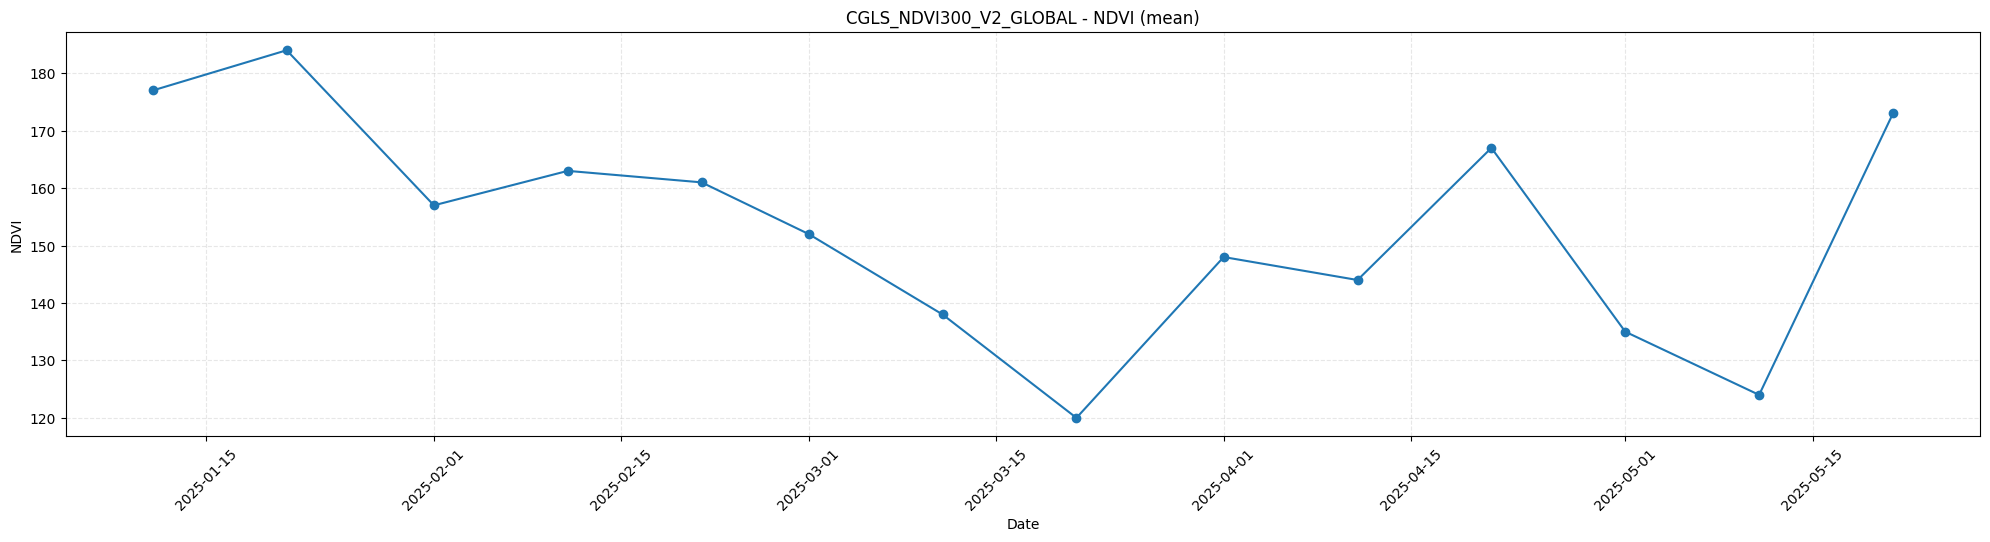

In [12]:
dates = []
values = []
for k, v in data.items():
    val = v[0][0]  # Extract inner value
    if val is not None:
        dates.append(datetime.fromisoformat(k.replace('Z', '+00:00')))
        values.append(val)

# Plot
plt.figure(figsize=(20, 5))
plt.plot(dates, values, marker='o', linestyle='-')
plt.title(f"{collection} - {band} (mean)")
plt.xlabel("Date")
plt.ylabel(band)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.show()